# CyNetDiff Demo

This notebook is meant as a demonstration of the capabilities of the CyNetDiff library for simulating network diffusion. We will go through some typical use cases that highlight how CyNetDiff enables execution of network diffusion simulations on larger graphs.

## Background

We briefly review background on network diffusion. For our purposes, network diffusion is a stochastic process modeling the spread of trends through a graph. Nodes are either "active" (adopting the trend) or "inactive", and we are usually interested in the total number of active nodes by the end of this process. At the start, only nodes in the seed set are active, and later nodes are activated by rules dictated by the model. The process stops once no more nodes can be activated.

As these models are stochastic, computing the number of activated nodes is done by Monte-Carlo sampling, which can be very expensive once the number of samples or size of the graph become large.

Two of the most common models are Independent Cascade and Linear Threshold, and we will focus on Independent Cascade for this demo.


In [1]:
# Imports

from IPython.display import display
import networkx as nx
import random
import matplotlib.pyplot as plt
from cynetdiff.utils import (
    networkx_to_ic_model,
    set_activation_random_sample,
    set_activation_weighted_cascade,
    set_activation_uniformly_random,
)
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mod_config
import numpy as np
from coloraide import Color
import heapq
import demo_backend as db
import typing as t
from tqdm.notebook import trange, tqdm


import time
import pygraphviz


Graph = nx.Graph | nx.DiGraph
RANDOM_SEED = hash("CyNetDiff is very fast!")

# Simulating Diffusion

As a motivating example, suppose we would like to simulate an independent cascade a graph with a randomly chosen seed set. If we define the graph with standard NetworkX functions, then we can easily run multiple simulations with CyNetDiff.


In [2]:
n = 1_000  # Number of nodes in the graph
p = 0.01  # Probability of an edge
graph = nx.gnp_random_graph(n, p, RANDOM_SEED)
# Set activation probability to 0.1 on every edge
set_activation_random_sample(graph, {0.1})

k = 10  # Number of seed nodes
seeds = random.sample(list(graph.nodes()), k)

# Number of trials to average
num_trials = 1_000

total_activated = 0.0

# Initialize the independent cascade model
ic_model = networkx_to_ic_model(graph)
ic_model.set_seeds(seeds)

for _ in range(num_trials):
    ic_model.advance_until_completion()
    total_activated += ic_model.get_num_activated_nodes()
    ic_model.reset_model()

# Get the average number activated.
avg_activated = total_activated / num_trials
print(f"Average number of activated nodes: {avg_activated}")

Average number of activated nodes: 106.629


# Simple Benchmarks (start the next cell before reading)

For large graphs run over many trials, this simulation task can be computationally expensive. To observe how CyNetDiff tackles this compared to other Python packages, we have functions that do diffusion averaging as above and display a progress bar. The `diffuse_ndlib` function runs the diffusion process with the [NDlib](https://ndlib.readthedocs.io/en/latest/) library, `diffuse_python` is an optimized pure python implementation, and `diffuse_CyNetDiff` uses our library.

`db.simple_benchmark` simulates diffusions on a graph with all three libraries, including a progress bar and timing information.


In [3]:
db.simple_benchmark(graph)

Number of randomly chosen seed nodes: 10
Graph nodes: 1_000
Graph edges: 4_909
Number of trials: 1_000
Starting diffusion with NDlib.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_ndlib' took: 10.0556 sec
Starting diffusion with pure Python.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_python' took: 0.6149 sec
Starting diffusion with CyNetDiff.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_CyNetDiff' took: 0.0467 sec
NDlib avg activated: 110.367
Pure Python avg activated: 111.419
CyNetDiff avg activated: 111.574


CyNetDiff is very fast, performing much better than even optimized pure Python. This is a result of using a complied extension module, with data structures that minimize memory usage (graphs are stored in [CSR format](https://www.usenix.org/system/files/login/articles/login_winter20_16_kelly.pdf)). Observe that we have similar performance on different graphs and weighting schemes.


In [4]:
# Small world graph.
small_world_graph = nx.watts_strogatz_graph(1_000, 10, 0.01, seed=RANDOM_SEED)
set_activation_random_sample(small_world_graph, {0.1, 0.01, 0.001})

# Paley graph with weighted cascade.
paley_graph = nx.paley_graph(500).to_directed()
set_activation_weighted_cascade(paley_graph)

# Lobster graph with weights chosen uniformly at random.
lobster = nx.random_lobster(2000, 0.2, 0.2, seed=RANDOM_SEED)
set_activation_uniformly_random(lobster, range_start=0.2, range_end=0.8)

# Change the benchmark graph to see different runs
db.simple_benchmark(lobster)

Number of randomly chosen seed nodes: 10
Graph nodes: 1_932
Graph edges: 1_931
Number of trials: 1_000
Starting diffusion with NDlib.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_ndlib' took: 7.0066 sec
Starting diffusion with pure Python.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_python' took: 0.1391 sec
Starting diffusion with CyNetDiff.


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffuse_CyNetDiff' took: 0.0137 sec
NDlib avg activated: 31.713
Pure Python avg activated: 32.029
CyNetDiff avg activated: 32.032


# TODO add pooch snap downloader and put small benchmark.


# Visualizations

One way to leverage the high performance of CyNetDiff is by scaling up the complexity of visualizations. The visualization code in this section extracts information from CyNetDiff and renders this using external libraries.

## Heatmap

As a motivating example, suppose we want to visualize which nodes are activated most often across trials during the network diffusion process. This is possible by recording which nodes get activated after each trial, and maintaining counts across trials.

Below, we provide code that creates this visualization. Nodes that are visited more often are displayed in red and less visited nodes are in blue. Observe that seed nodes (which are always visited) are red.


Seeds:  [11, 7, 40, 42]


  0%|          | 0/1000 [00:00<?, ?it/s]

func:'diffusion_get_frequencies' took: 0.0416 sec


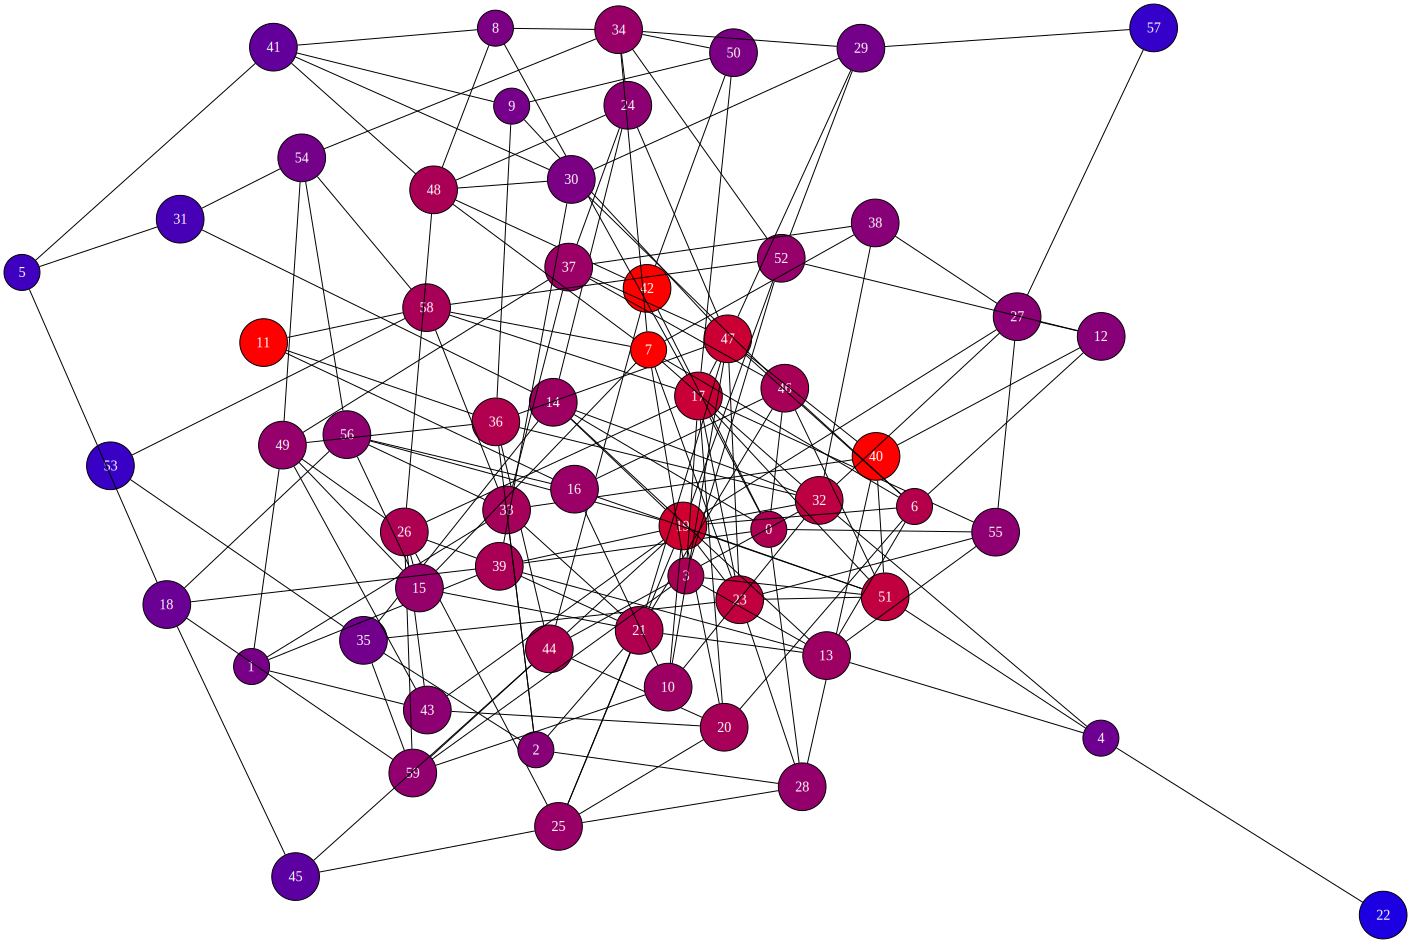

In [20]:
def draw_graph(graph: Graph, frequencies: t.Optional[t.Dict[int, int]] = None):
    A = nx.nx_agraph.to_agraph(graph)  # convert to a graphviz graph
    A.node_attr["width"] = 0.5
    A.node_attr["shape"] = "circle"

    if frequencies is not None:
        heat_iterpolator = Color.interpolate(["blue", "red"], space="srgb")

        max_freq = max(frequencies.values())
        for node in graph.nodes():
            freq = frequencies.get(node, 0)
            viz_node = A.get_node(node)
            viz_node.attr["fillcolor"] = heat_iterpolator(freq / max_freq).to_string(
                hex=True
            )
            viz_node.attr["style"] = "filled"
            viz_node.attr["fontcolor"] = "white"

    A.layout(prog="fdp")
    return A


# Generate the graph and set activation probabilities uniformly to 0.2.
small_graph = nx.gnp_random_graph(60, 0.1)
seeds = random.sample(list(small_graph.nodes()), 4)
set_activation_random_sample(small_graph, {0.25})

# Print number of seeds and display the graph.
print("Seeds: ", seeds)
cascade_frequencies = db.diffusion_get_frequencies(small_graph, seeds)
draw_graph(small_graph, cascade_frequencies)

# Diffusion Over Time

As another example, suppose we want to plot the growth in the number of activated nodes over time under different diffusion scenarios. To do this, we leverage [`Matplotlib`](https://matplotlib.org/) along with data gathered from CyNetDiff. In this example, we will be comparing the quality of diffusion by choosing different seed sets over the same randomly generated graph.

For this example, we will compare the number of activated nodes between a randomly chosen seed set, and using the highest degree nodes as seeds. Observe that the high-degree nodes activate a substantially higher number of nodes than the randomly chosen subset.


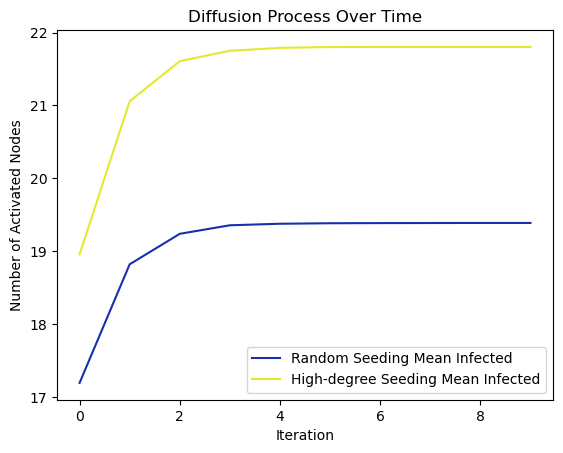

In [18]:
diff_graph = nx.watts_strogatz_graph(1_000, 5, 0.1, seed=RANDOM_SEED)

num_seeds = 12
random_seeds = set(random.sample(list(diff_graph.nodes()), num_seeds))
high_deg_seeds = sorted(diff_graph.nodes(), key=diff_graph.degree, reverse=True)[
    :num_seeds
]

db.plot_num_nodes_activated(
    [
        ("Random Seeding", diff_graph, random_seeds),
        ("High-degree Seeding", diff_graph, high_deg_seeds),
    ]
)

For a second example using a similar setup, let's plot the mean number of infected nodes of different weighting schemes.

# TODO add written description of the three weighting schemes and independent cascade.


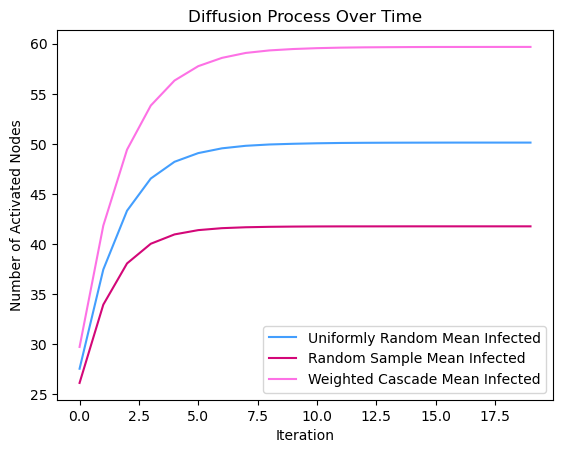

In [32]:
# Make a copy of graph and set activation probability uniformly at random in a range.
uniform_prob_graph = diff_graph.copy()
set_activation_uniformly_random(uniform_prob_graph, range_start=0.15, range_end=0.3)

# Set activation probability based on random sample.
random_prob_graph = diff_graph.copy()
set_activation_random_sample(random_prob_graph, {0.15, 0.2, 0.25})

# Set activation probability to 1/in_degree(v)
weighted_cascade_graph = diff_graph.to_directed()
set_activation_weighted_cascade(weighted_cascade_graph)

num_seeds = 12
random_seeds = set(random.sample(list(diff_graph.nodes()), num_seeds))
high_deg_seeds = sorted(diff_graph.nodes(), key=diff_graph.degree, reverse=True)[
    :num_seeds
]

db.plot_num_nodes_activated(
    [
        ("Uniformly Random", uniform_prob_graph, high_deg_seeds),
        ("Random Sample", random_prob_graph, high_deg_seeds),
        ("Weighted Cascade", weighted_cascade_graph, high_deg_seeds),
    ]
)

In [8]:
# O = nx.fast_gnp_random_graph(15000, 2)
graphs = []

base_graph = nx.watts_strogatz_graph(15_000, 10, 0.01)


graphs = [
    nx.watts_strogatz_graph(15_000, 10, 0.01),
    nx.watts_strogatz_graph(15_000, 10, 0.02),
    nx.watts_strogatz_graph(15_000, 10, 0.05),
    nx.watts_strogatz_graph(15_000, 10, 0.10),
    nx.watts_strogatz_graph(15_000, 10, 0.20),
]
graph = nx.watts_strogatz_graph(15_000, 10, 0.01)
# B = nx.erdos_renyi_graph(100, 0.1)
# nx.set_edge_attributes(G, 0.01, "activation_prob")
# nx.set_edge_attributes(O, 0.01, "activation_prob")
# nx.set_edge_attributes(B, 0.01, "activation_prob")

In [ ]:
def celf(
    graph: Graph, k: int, method: str, mc: int = 1_000
) -> tuple[set[int], list[float]]:
    """
    Input: graph object, number of seed nodes
    Output: optimal seed set, resulting spread, time for each iteration
    Code adapted from this blog post:
    https://hautahi.com/im_greedycelf
    """

    # Make cynetdiff model
    cynetdiff_model = networkx_to_ic_model(graph)

    # NDLib Model
    ndlib_model = ep.IndependentCascadesModel(graph)

    config = mod_config.Configuration()

    # Assume that thresholds were already set.
    for u, v, data in graph.edges(data=True):
        config.add_edge_configuration("threshold", (u, v), data["activation_prob"])

    # Don't randomly infect anyone to start, just use given seeds.
    config.add_model_parameter("fraction_infected", 0.0)
    ndlib_model.set_initial_status(config)

    # Prepare graph
    dir_graph = graph
    if not dir_graph.is_directed():
        dir_graph = dir_graph.to_directed()

    # Run the CELF algorithm
    marg_gain = []

    # First, compute all marginal gains
    print("Computing initial marginal gains.")
    for node in tqdm(list(dir_graph.nodes())):
        marg_gain.append(
            (
                -compute_marginal_gain(
                    cynetdiff_model, ndlib_model, dir_graph, node, set(), mc, method
                ),
                node,
            )
        )

    heapq.heapify(marg_gain)

    max_mg, selected_node = heapq.heappop(marg_gain)
    S = {selected_node}
    spread = -max_mg
    spreads = [spread]

    print("Performing greedy selection.")
    for _ in trange(k - 1):
        while True:
            current_mg, current_node = heapq.heappop(marg_gain)
            print(current_mg, current_node)
            new_mg_neg = -compute_marginal_gain(
                cynetdiff_model, ndlib_model, dir_graph, current_node, S, mc, method
            )

            if new_mg_neg > current_mg:
                heapq.heappush(marg_gain, (new_mg_neg, current_node))
                break
            else:
                heapq.heappush(marg_gain, (current_mg, current_node))

        spread += -new_mg_neg
        S.add(current_node)
        spreads.append(spread)

    return S, spreads

In [ ]:
large_graph = nx.watts_strogatz_graph(1_000, 10, 0.01)
set_activation_random_sample(large_graph, {0.1})

In [ ]:
celf(large_graph, 10, "cynetdiff", 1_00)
# tqdm.__version__

Computing initial marginal gains.


/home/eliotwr/.local/lib/python3.11/site-packages/ndlib/models/DiffusionModel.py:169: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'compute_marginal_gain' is not defined